# 2021 Wieviele Sitze Parteien haben und haben sollten

In [1]:
import pandas as pd
import numpy as np
import cleandata as cd
import matplotlib
from voting import apportionment

In [2]:
df_raw = pd.read_csv('../data/Gemeinde_Exekutive - daten.csv')
df_2019 = pd.read_csv('../data/kantonsrat2019.csv')

## Clean Data

In [3]:
df_raw = cd.clean(df_raw)

# Clean Gemeinde-Names for Join
df_raw['Gemeinde'] = df_raw['Gemeinde'].str.replace(' (ZH)', '', regex=False)

Jahrgänge nicht zugeordnet: 15
Partei nicht zugeordnet: 9
Keine Jahrgänge: 21


## Clean Kantonsratswahl

In [4]:
# Rename Wahlkreise
df_2019.loc[df_2019.Gemeindenamen.str.contains('Winterthur', regex=False), 'Gemeindenamen'] = 'Winterthur'
df_2019.loc[df_2019.Gemeindenamen.str.contains('Zürich, Kreis', regex=False), 'Gemeindenamen'] = 'Zürich'
df_2019.loc[df_2019.Gemeindenamen.str.contains('Ellikon a.d.Thur', regex=False), 'Gemeindenamen'] = 'Ellikon an der Thur'

# Transform
df_2019['partei_c'] = df_2019['Liste'].apply(cd.transform_partei)

# Group by Gemeinde
df_2019 = df_2019.groupby(['Gemeindenamen', 'partei_c']).agg({'Stimmen': 'sum'}).reset_index()

# Calc %
df_2019['2019'] = df_2019.apply(lambda row: round(100 / df_2019.loc[df_2019.Gemeindenamen == row['Gemeindenamen'], 'Stimmen'].sum() * row['Stimmen'], 2), axis=1)

## Calc "is"

In [5]:
df = df_raw.pivot_table(index='Gemeinde', columns='partei_c', values='Name', aggfunc='count')
df = df.fillna(0)

## Calc "should" - Loop di loop

In [6]:
records = []

for i, row in df_2019.groupby('Gemeindenamen').count().reset_index().iterrows():
    record = {'Gemeinde': row['Gemeindenamen']}
    
    df_g = df_2019[df_2019.Gemeindenamen == row['Gemeindenamen']].copy().reset_index()
    
    df_g['should'] = apportionment.hagenbach_bischoff(list(df_g['2019']), len(df_raw[df_raw.Gemeinde == row['Gemeindenamen']]))
    
    for i, row in df_g[df_g.should > 0].sort_values('should', ascending=False).iterrows():
        record[row['partei_c']] = row['should']
        
    records.append(record)

df_should = pd.DataFrame(records)
df_should = df_should.fillna(0)

## Merge

In [7]:
# Group should
df_s = df_should.drop(columns='Gemeinde')
df_s = pd.DataFrame(df_s.sum())
df_s.rename(columns={0: 'should'}, inplace=True)

# Group is
df_i = df.reset_index(drop=True)
df_i = pd.DataFrame(df_i.sum())
df_i.rename(columns={0: 'is'}, inplace=True)

df_joined = df_i.join(df_s)
df_joined = df_joined.fillna(0)

# Calc dif
df_joined['diff'] = df_joined['should'] - df_joined['is']

# Remove Vacant
df_joined = df_joined[df_joined.index != 'vacant']

# Sort
df_joined = df_joined.sort_values('diff')

# Nicelify
df_joined.index = df_joined.index.map(cd.nicelify_party)

# Export for DataWrapper
df_joined.to_csv('../export/should_is.csv')

df_joined

,is,should,diff
partei_c,,,
parteilos,366.0,0.0,-366.0
andere,55.0,0.0,-55.0
FDP,221.0,181.0,-40.0
CVP/Die Mitte,43.0,5.0,-38.0
EVP,20.0,12.0,-8.0
BDP,4.0,1.0,-3.0
al,1.0,1.0,0.0
EDU,1.0,4.0,3.0
Grüne,10.0,64.0,54.0


In [8]:
df_pr = df_joined.copy()
df_pr['%'] = round(100 / df_pr['should'].sum() * df_pr['should'], 1)
df_pr

,is,should,diff,%
partei_c,,,,
parteilos,366.0,0.0,-366.0,0.0
andere,55.0,0.0,-55.0,0.0
FDP,221.0,181.0,-40.0,17.7
CVP/Die Mitte,43.0,5.0,-38.0,0.5
EVP,20.0,12.0,-8.0,1.2
BDP,4.0,1.0,-3.0,0.1
al,1.0,1.0,0.0,0.1
EDU,1.0,4.0,3.0,0.4
Grüne,10.0,64.0,54.0,6.3


<AxesSubplot:xlabel='partei_c'>

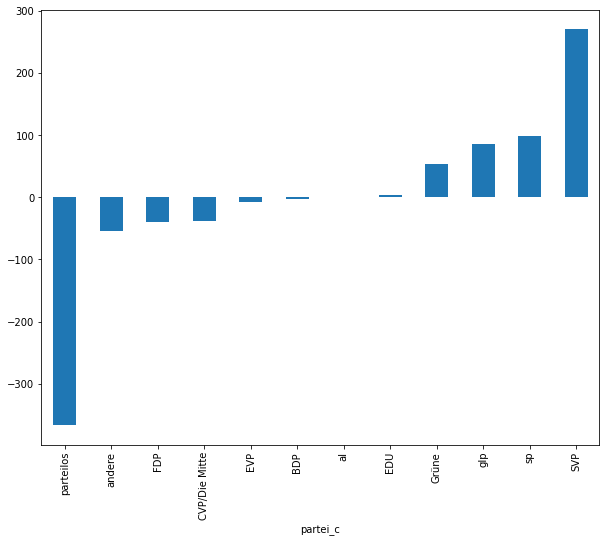

In [9]:
df_joined['diff'].plot.bar(figsize=(10, 8))

## Check Gemeinden with SVP > 50% Wähleranteil

In [10]:
# Prepare is
df_is = df.copy()
df_is['total'] = df_is.sum(axis=1)
df_is['svp_is'] = round(100 / df_is['total'] * df_is['svp'])

df_svp = df_2019[df_2019.partei_c == 'svp']
df_svp = df_svp[['Gemeindenamen', '2019']]
df_svp.rename(columns={'2019': 'svp_2019', 'Gemeindenamen': 'Gemeinde'}, inplace=True)

df_svp = df_is.merge(df_svp, how='left', on='Gemeinde')

df_svp['delta'] = abs(df_svp['svp_is'] - df_svp['svp_2019'])

df_svp[df_svp.svp_2019 >= 50].sort_values('svp_2019', ascending=False)

,Gemeinde,al,bdp,cvp,edu,evp,fdp,glp,grüne,parteilos,sp,svp,vacant,verschiedene,total,svp_is,svp_2019,delta
67,Hüttikon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,5.0,40.0,60.08,20.08
53,Hagenbuch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,4.0,0.0,0.0,6.0,67.0,58.63,8.37
146,Weiach,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,58.13,58.13
0,Adlikon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,2.0,0.0,0.0,5.0,40.0,55.98,15.98
5,Altikon,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,6.0,33.0,54.91,21.91
65,Höri,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,0.0,0.0,5.0,20.0,52.78,32.78
43,Fischenthal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,52.38,52.38


In [ ]:
df_svp.sort_values('delta', ascending=False).head(20)

## In wievielen Gemeinden war SVP 2019 stärkste Kraft?

In [ ]:
df_svp = pd.pivot_table(df_2019, index='Gemeindenamen', columns='partei_c', values='2019')

df_svp['svp_stronges'] = df_svp.apply(lambda row: max(row['al'], row['bdp'], row['cvp'], row['evp'], row['glp'], row['grüne'], row['sp'], row['svp'], row['verschiedene']) == row['svp'], axis=1)

df_svp.head()